---
---
# Introducción


En términos laxos, las redes neuronales pueden ser:

*   *Encoders*: Encuentran patrones en datos brutos para producir unformación de valor.
*   *Decoders*: Hacen el proceso opuesto; es decir, a partir de representaciones de información, tratan de reproducirla en mayor resolución.
*   Combinación de ambas técnicas.

Nos servimos de esta excelente imagen ofrecida por el curso de *Deep Learning* de *MIT*:


![Deep learning concepts](https://i.imgur.com/EAl47rp.png)

Típicamente, las redes neuronales se organizan en **capas** en las cuales realizamos cálculos (lineales o no lineales), y es la destreza combinando ambas lo que nos proporciona excelentes resultados. En este curso, abordaremos las tres primeras arquitecturas del aprendizaje supervisado en el esquema anterior, dada su expandida popularidad.

---
---
#Análisis descriptivo: *Feed-Forward NN*
Veamos ahora cómo traducir toda esta lógica a un ejemplo concreto, para lo que aprovecharemos e implementaremos manualmente una sencilla estructura de *FF-NN*.

---
##Introducción
El proceso de *FF-NN* puede resumirse en cinco pasos:
*   *Inicialisation*: En base a las dimensiones que se hayan configurado de las distintas capas, instanciamos valores aleatorios a los pesos y los *bias*.
*   *Forward propagation*: Realizamos los cálculos en base a las conexiones y pesos correspondientes a la capa.
*   *Error*: Calculamos la función de coste asociada a los cálculos anteriores.
*   *Backpropagation*: Ponderamos el margen de error que proviene de cada capa y/o cada *bias*.
*   *Learning*: Mediante un factor de aprendizaje (que llamaremos *alpha*), reajustamos los pesos del modelo.

Teniendo en cuenta este proceso, en la cual el paso cuatro es la más importante sin duda alguna, generamos una estructura base para implementar nuestra lógica:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # Realiza los cálculos pertinentes a la capa
    def forward_propagation(self, input):
        raise NotImplementedError

    # Calcula el error atribuído a los pesos de una capa
    def backward_propagation(self, error, alpha):
        raise NotImplementedError

Cabe mencionar que, en nuestro caso, **trataremos las funciones de activación como capas individuales**, a fin de dar mayor libertad a la configuración de la red neuronal.

---
##Forward propagation

En términos formales, describiríamos nuestro *dataset* como:

$$X\in \mathcal{M}(n_{input},n_{features}),\, y\in\mathcal{M}(n_{input},n_{output})$$

Tomando una muestra de nuestros datos, lo siguiente que debemos hacer es añadir una capa densa, representada por la siguiente matriz (dado que es una capa *fully connected*), además de un vector *b* que representa el *bias*:

$$W_1\in \mathcal{M}(n_{features},n_{W_1}),\,b\in\mathcal{M}(n_{input},n_{W_1})$$

Con ella,somos capaces de transformar la información de un vector de dimensiones $(n_{input},n_{features})$ en otro de dimensión $(n_{input},n_{W1})$:

$$z_{1}^{(i)}=X_i W_1+b_i=\left(\begin{array}{ccl}x_{i,1} & \ldots & x_{i,n_{features}}\end{array}\right) \left(\begin{array}{ccl}\omega_{1,1} & \ldots & \omega_{1,n_{W_1}}\\\vdots&\ddots&\vdots\\\omega_{n_{features},1} & \ldots & \omega_{n_{features},n_{W_1}}\end{array}\right) + \left(\begin{array}{ccl}b_{i,1} & \ldots & b_{i,n_{W_1}}\end{array}\right) \in \mathcal{M}(1,n_{W_1})$$

A este vector, le aplicamos una **función de activación**:

$$h_1^{(i)}=\text{act}(z_1^{(i)})\in \mathcal{M}(1,n_{W_1})$$

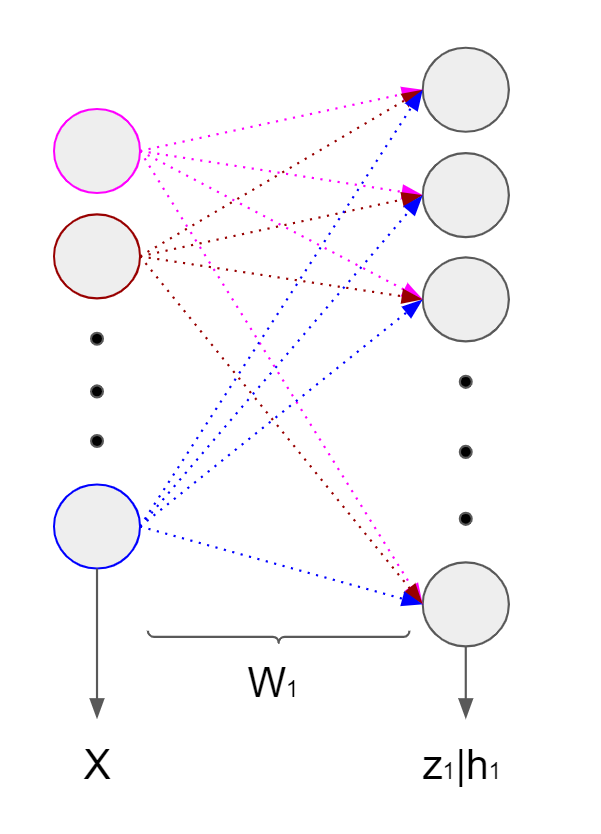

Podemos iterar este proceso para dar tanta profundidad a nuestra red neuronal como se quiera. En concreto, para la iteración *j*, tendremos la estructura:

$$W_j\in \mathcal{M}(n_{W_{j-1}},2)\longrightarrow z_j^{(i)}=h_{j-1}^{(i)} W_j+b_j^{(i)}\in \mathcal{M}(1,n_{W_j})\longrightarrow h_j^{(i)}=\text{act}(z_j^{(i)})\in \mathcal{M}(1,n_{W_j})$$

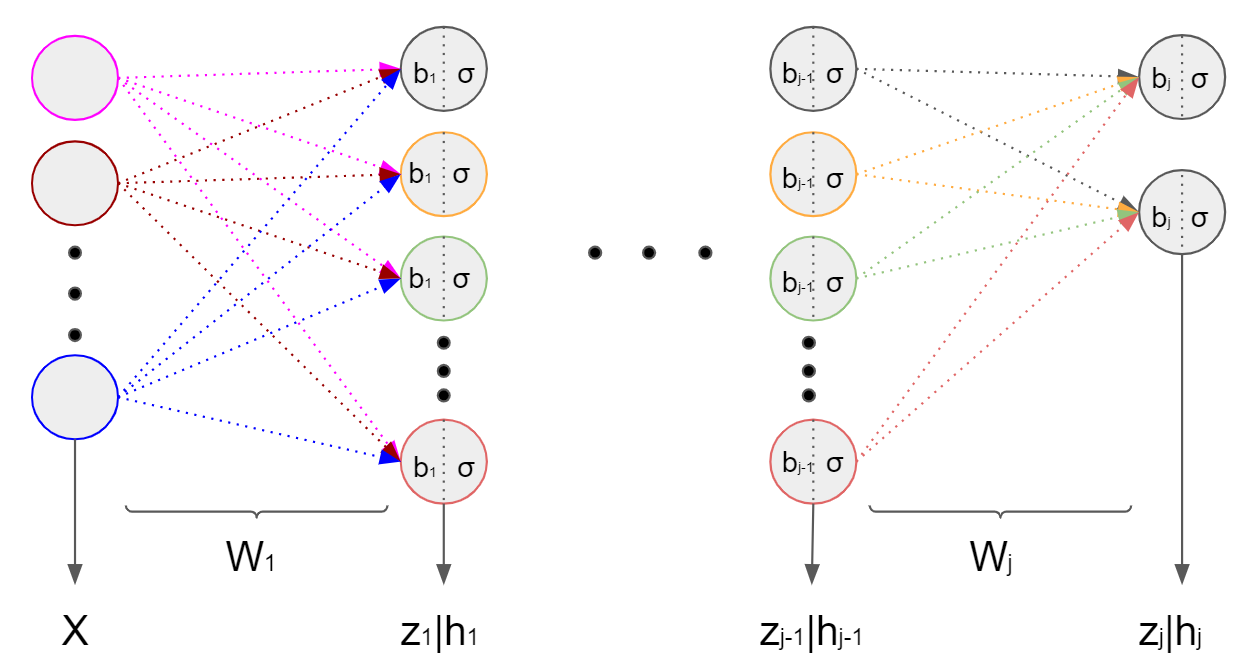

Debemos tener en cuenta que la última capa que se añada debe tener la misma salida que el *output* del modelo, esto es, *n_output*.

---
##Calculamos función de pérdida
Es aquí cuando comparamos, mediante una función de pérdida predefinida, la diferencia entre lo obtenido y el valor real para posteriormente buscar qué factores provocaron tal error:

* En problemas donde la variable respuesta es numérica y continua, tomamos típicamente el error cuadrático medio:

$$J(y,h_j)=\frac{1}{n}\sum_{i=1}^{n}(y_i-h_{j}^{(i)})^2$$

* En problemas de clasificación, empleamos habitualmente la *categorial crossentropy*:

$$ J(y,h_j)=-\sum_{i=1}^{n_{output}} y_i\,\text{log}(h_i) $$

In [3]:
def J(y_true, y_pred):
  return np.square(y_true-y_pred).sum()/y.shape[0]

---
##Backpropagation
Tratamos ahora de explicar de qué componentes procede el error cometido y en qué medida; concretamente, diseminaremos el error cometido en cada iteración aplicando la **regla de la cadena**.

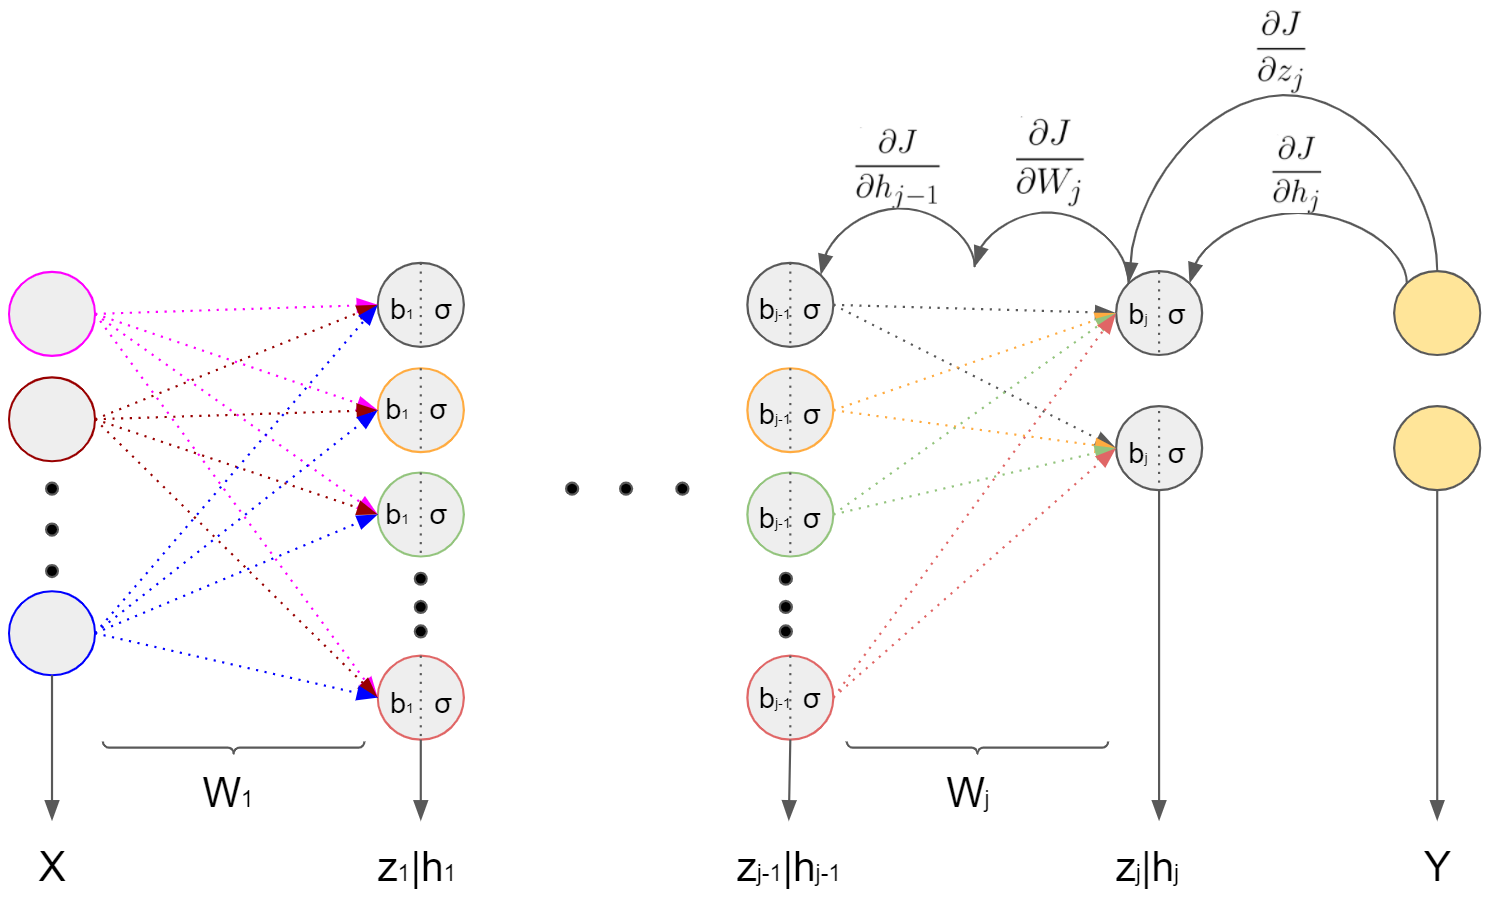

###Input, pesos y *bias*

Dada la estructura recursiva de las capas, necesitamos obtener el error resprendido tanto hacia el input (que será el error cometido en la capa anterior), como el error en la matriz de pesos de dicha capa, como en su *bias*, en base a la estructura de la capa y el error final.

* El error justificado por el *bias* es simplemente el error "visible":

$$\frac{\partial J}{\partial b_j}=\frac{\partial J}{\partial z_{j}}$$

* El error atribuíble a los pesos viene dado por el valor del *input* de la capa traspuesto por el error final:

$$\frac{\partial J}{\partial W_j}=\frac{\partial J}{\partial z_{j}}\frac{\partial z_j}{\partial W_j}=(h_{j-1})^t \frac{\partial J}{\partial z_{j}}$$

* El error correspondiente al *input* es el error final por la matriz de pesos traspuesta:

$$\frac{\partial J}{\partial h_{j-1}}=\frac{\partial J}{\partial z_{j}}\frac{\partial z_j}{\partial W_j}\frac{\partial W_j}{\partial h_{j-1}}=\frac{\partial J}{\partial z_{j}}\frac{\partial z_j}{\partial h_{j-1}}=\frac{\partial J}{\partial z_{j}}(W_{j})^t$$

###Función de activación

De modo independiente, podemos calcular el error de la capa función de activación como el error visible por la derivada de la función de activación aplicada al *input* (multiplicando componente a componente, no de forma matricial):

$$\frac{\partial J}{\partial \text{act}}=\frac{\partial J}{\partial z_{j}}\bigodot \text{act}'(z_j)$$

---
##Learning rate
Finalmente, fijamos un parámetro de aprendizaje que controle la corrección que hacemos de las matrices de pesos y aplicamos los cambios, que denotaremos por *alpha*.

$$\begin{array}{ccl} W_j &\mapsto & W_j-\alpha\frac{\partial J}{\partial W_j} \\ b_j & \mapsto & b_j-\alpha\frac{\partial J}{\partial b_j} \end{array}$$

---
---
#Implementación *FF-NN*

Si unificamos todo el código relativo a una capa densa, nos quedaría como sigue:



---
##Baseline

In [4]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # Realiza los cálculos pertinentes a la capa
    def forward_propagation(self, input):
        raise NotImplementedError

    # Calcula el error atribuído a los pesos de una capa
    def backward_propagation(self, output_error, alpha):
        raise NotImplementedError

---
##Capa densa

In [5]:
# Creamos una clase que hereda el esquema de Layer
class DenseLayer(Layer):
    # Configuración inicial para todos los métodos de la clase
    def __init__(self, n_input, n_output):
        self.weights = np.random.rand(n_input, n_output) - 0.5
        self.bias = np.random.rand(1, n_output) - 0.5

    def forward_propagation(self, input):
        self.input = input
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, alpha):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        #bias_error = output_error

        # Aplicamos aprendizaje
        self.weights -= alpha * weights_error
        self.bias -= alpha * output_error
        return input_error

---
##Función de activación

In [6]:
# Creamos una clase que hereda el esquema de Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_der):
        self.activation = activation
        self.activation_der = activation_der

    def forward_propagation(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return self.output

    #En este caso no hay fase de aprendizaje, luego se omite
    def backward_propagation(self, output_error, alpha):
        return self.activation_der(self.input) * output_error

Pasamos a comentar algunas funciones populares:
*   Sigmoide: Tiene como ventaja su aplicabilidad a problemas binarios, pero no está centrada en el origen ni computa bien gradientes cuando satura, además de que calcular exponenciales es computacionalmente costoso.



In [7]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def sigmoid_der(z):
  return sigmoid(z)*(1-sigmoid(z))

*   Tangente hiperbólica: Esta función sí está centrada en el origen, aunque sigue teniendo el mismo problema con los gradientes.

In [8]:
def tanh(z):
    return np.tanh(z);

def tanh_der(z):
    return 1-np.tanh(z)**2;

*   ReLU: Tiene una convergencia mayor, ya que no satura con el gradiente, pero tiene el gran inconveniente de que no actualiza valores de parámetros cuando el input es menor que cero.

In [9]:
def Relu(z):
    y = z.copy()
    y[z<0] = 0
    return y

def Relu_der(z):
    y = z.copy()
    y[z<0] = 0
    y[z>=0] = 1
    return y

*   Leaky ReLU: Introducida por *(Mass et al., 2013)*, *(He et al., 2015)*, pretende eliminar el problema del aprendizaje cuando el input es negativo.

In [10]:
def LeakyRelu(z):
    y = z.copy()
    y[z<0] = 0.01*z[z<0]
    return y

def LeakyRelu_der(z):
    y = z.copy()
    y[z<0] = 0.01
    y[z>=0] = 1
    return y

*   *Softmax*: Nos proporciona un enfoque probabilístico de la salida, adecuado para optimizar problemas de clasificación:

In [11]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z), axis = -1, keepdims = True)

def softmax_der(z):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    s = softmax(z).reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

---
##Función de coste

In [12]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_der(y_true, y_pred):
    return 2*(y_true-y_pred)/y_true.size

In [13]:
def categorical_crossentropy(y_true, y_pred):
    return -np.sum(y_true*np.log(softmax(y_pred)+1e-08))

def categorical_crossentropy_der(y_true, y_pred):
    return softmax(y_pred)-y_true

---
##Clase para entrenamiento y predicción de resultados

In [14]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_der = None

    # Añadimos capa a la red de la misma forma que TensorFlow
    def add(self, layer):
        self.layers.append(layer)

    # Implementamos en la clase la función de coste y su gradiente
    def use(self, loss, loss_der):
        self.loss = loss
        self.loss_der = loss_der

    # Predicción
    def predict(self, input):
        samples = input.shape[0]
        result = []

        # Ejecutamos la red con todos los datos
        for i in range(samples):
            # Forward propagation
            output = input[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # Entrenamos la red
    def fit(self, X_train, y_train, epochs, alpha):

        samples = X_train.shape[0]

        # Bucle de entrenamiento
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # Forward propagation
                output = X_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # Calculamos función de coste
                err += self.loss(y_train[j], output)

                # Backward propagation
                error = self.loss_der(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, alpha)

            # Calculamos error medio en todas las estimaciones
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

---
---
# Ejemplo: Operador XOR

Una aplicación clásica de adaptación de redes neuronales a problemas no lineales es la predicción del operador XOR. De manera tabular, tenemos dos *features* binarias y una *label* del mismo tipo que toma el valor uno si alguna de las features es uno, y cero en otro caso.

In [17]:
# Librerías
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Creamos datos
X = np.random.randint(low = 0, high = 2, size = (1000,1,2))
y = np.zeros((1000, 2), dtype=int)
y[np.arange(1000), np.max(X.reshape(1000,2), axis = -1)] = 1
# Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state = 123)

In [18]:
#Parámetros
n_input = X.shape[-1]
n_W1 = 4
n_output = y.shape[-1]

# Network
net = Network()
net.add(DenseLayer(n_input, n_W1))
net.add(ActivationLayer(LeakyRelu, LeakyRelu_der))
net.add(DenseLayer(n_W1, n_output))

# Entrenamos
net.use(categorical_crossentropy, categorical_crossentropy_der)
net.fit(X_train, y_train, epochs=10, alpha=0.01)

# Test
out = net.predict(X_test)
y_pred = np.zeros((y_test.shape[0], n_output))
for idx in range(y_pred.shape[0]):
  y_pred[idx,:] = out[idx]

# Informe
print(classification_report(np.argmax(y_test, axis = -1).astype('int'), np.argmax(y_pred, axis = -1).astype('int')))

epoch 1/10   error=0.602283
epoch 2/10   error=0.535947
epoch 3/10   error=0.484533
epoch 4/10   error=0.413158
epoch 5/10   error=0.298024
epoch 6/10   error=0.176125
epoch 7/10   error=0.109380
epoch 8/10   error=0.074332
epoch 9/10   error=0.054541
epoch 10/10   error=0.042346
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       384

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

